# Show and Tell v23
## Milestone 3
## Rishi Ghia, Santnam Bakshi, Purvansh Jain

In this notebook, are present all the same sections as milestone 2, but with the ResNet replaced by a SWIN Transformer


In [1]:
!pip install torch torchvision transformers
!pip install --upgrade transformers

In [2]:
import os
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from collections import Counter
from itertools import chain
from PIL import Image
import random
import torch
from transformers import ViTFeatureExtractor, ViTModel
from transformers import SwinForImageClassification
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f'Using device: {device}')

Using device: cuda


# Dataset Class

Below we have defined the dataset class, which shall be used throughout the project to access the images, and their respective captions. 

In [4]:
class CustomCocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        # Create a mapping from image IDs to filenames
        self.id_to_filename = {item['id']: item['file_name'] for item in self.data['images']}

        # Create a mapping from image IDs to captions
        # Note that there might be multiple captions per image
        self.id_to_captions = {}
        for annotation in self.data['annotations']:
            image_id = annotation['image_id']
            if image_id not in self.id_to_captions:
                self.id_to_captions[image_id] = []
            self.id_to_captions[image_id].append(annotation['caption'])

        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # Retrieve the image info
        image_info = self.data['images'][idx]
        image_id = image_info['id']
        img_filename = self.id_to_filename[image_id]

        # Load the image
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Retrieve the corresponding captions
        captions = self.id_to_captions[image_id][:1]
        return image, captions

Here we define a function to transform the dimensions and format of all the images to make them consistent in order to properly input them into the SWIN Transformer. 

In [5]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Resize to slightly larger than required size
    transforms.CenterCrop(224),  # Crop to the required size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data Loader and Dataset Initialization

Hyperparameters. 

The training dataset is about 118k images large, but all of it has not been used due to computational limitations. Batchsize and Epochs can also be increased given additional computational capacity. 

In [6]:
trainSize = 20480
valSize = 4096
batchSize = 32
num_epochs = 15

Initialize the dataset, including the train and validation data, and their respective captions, found in the .json files. Test data has not been used as it does not contain any captions, but the validation dataset shall serve as the test dataset for all intents and purposes. As a result, any validation/development to be done shall be performed on a subset of the train dataset which shall be disjoint from the data trained on. 

IID Sampling has been performed on the dataset in order to ensure that the subset selected does not contain any class imbalances. Further, the "shuffle" parameter has been turned to True within the data loader, thus each time the model is trained, samples are provided in a random order to reduce the chance of overfitting. 

In [7]:
# Initialize the dataset with the feature extractor
coco_dataset = CustomCocoDataset(
    root_dir='Dataset/train2017',
    annotation_file='Dataset/annotations_trainval2017/annotations/captions_train2017.json',
    transform=transform
)

coco_val_dataset = CustomCocoDataset(
    root_dir='Dataset/val2017',
    annotation_file='Dataset/annotations_trainval2017/annotations/captions_val2017.json',
    transform=transform
)

random.seed = 42

# Shuffle the indices
indices = list(range(len(coco_dataset)))
random.shuffle(indices)

# Take a subset of the first 2048 items
subset_indices = indices[:trainSize]
coco_dataset = Subset(coco_dataset, subset_indices)

val_indices = list(range(len(coco_val_dataset)))
random.shuffle(val_indices)
subset_val_indices = val_indices[:valSize]
coco_val_dataset = Subset(coco_val_dataset, subset_val_indices)

# DataLoader
data_loader = DataLoader(dataset=coco_dataset, batch_size=batchSize, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=coco_val_dataset, batch_size=batchSize, shuffle=True, num_workers=0)

# Testing Data Loader

This function shall allow for images within the dataset to be displayed in the notebook. 

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.axis('off')  # This line hides the axis
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

You can test if the data loader is working by running the below code block. It takes in one batch of images, and displays the first one from the batch. 

Size of the batch (images): torch.Size([32, 3, 224, 224])
Number of captions in this batch: 32


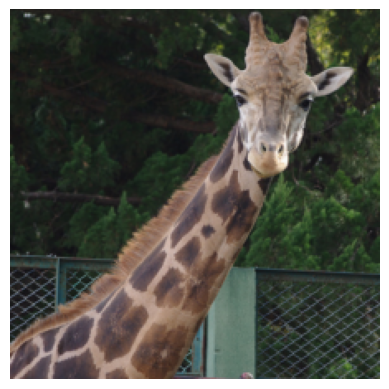

In [9]:
# Fetch one batch of images
for images, captions in data_loader:
    break

# If you want to display the size of this batch or perform any simple operation
print(f"Size of the batch (images): {images.size()}")
print(f"Number of captions in this batch: {len(captions[0])}")
imshow(images[0])

# Preprocess Captions

The 'preprocess_captions' function takes as argument the data loader, and while iterating through all the captions, prepends a start token 'startword' and appends an end token 'endword' to each caption. They are also changed to lowercase, and tokenized using .split(). 

A vocabulary is constructed from the captions, consisting of every word that occurs once or more (basically, all of them!)

In [10]:
nltk.download('punkt')

def preprocess_captions(data_loader):
    captions = []
    for _, caps in data_loader:
        for cap in caps[0]:
            updated_cap = f'startword {cap.lower()} endword'

            # Tokenize the updated caption
            tokens = updated_cap.split()
            captions.append(tokens)


    word_count = Counter()
    # Build a vocabulary
    for cap in captions:
        word_count.update(cap)

    min_word_freq = 1

    vocab = [word for word in word_count if word_count[word] >= min_word_freq]

    # Create a tokenizer and fit it on the updated captions
    tokenizer = Tokenizer(num_words=len(vocab))
    tokenizer.fit_on_texts([" ".join(caption) for caption in captions])
    return tokenizer, word_count, vocab

tokenizer, word_count, vocab = preprocess_captions(data_loader)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghiar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The code below is used during inference, helping convert token indices back to words. 

In [11]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# Function to convert a list of indices to words
def indices_to_words(indices):
    return ' '.join([index_to_word.get(index, '') for index in indices])

The below code allows us to expore the tokenizer and upload it to Google Colab, helping us skip the tokenizer step each time we run the code. 

In [12]:
import pickle

In [13]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Evaluation Script

Below is a code block to be used for evaluation, that takes as input a list containing predicted captions, and a list containing true captions. 

The metric used is the BLEU score. It has been used in several literature, such as: 

1. Show and Tell: A Neural Image Caption Generator
2. Show, Attend and Tell: Neural Image Caption Generation with Visual Attention
3. Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering

The BLEU (Bilingual Evaluation Understudy) Score is a widely used metric for evaluating the quality of machine-translated text against high-quality human translations. Its extensive use in research is attributed to its ability to provide a standardized, objective, and quantitative measure of translation quality. BLEU score efficiently correlates with human judgment, particularly at the corpus level, making it a valuable tool for assessing the overall translation quality.

In the realm of image captioning, BLEU is utilized to assess how closely a model's generated captions align with human-generated reference captions. This metric is crucial not only for verifying the factual correctness of the captions but also for ensuring linguistic similarity to human expression.

We have calculated 2 different kinds of BLEU score. Below stated are the advantages and disadvantages of each, along with why they have been used: 

When comparing individual caption scoring (sentence-level BLEU) and overall corpus scoring (corpus-level BLEU), there are notable differences. Sentence-level BLEU evaluates each generated caption against its reference, averaging these scores for a final result. This method, while insightful for individual translations, can be sensitive to caption length and may not consistently align with human judgment. On the other hand, corpus-level BLEU calculates the score over the entire dataset. This approach considers all n-grams in the generated corpus, providing a more comprehensive assessment of the model's performance. Corpus-level BLEU is typically more stable and accurately reflects the system's effectiveness, making it the preferred method for evaluating and comparing the performance of translation or captioning systems.

FInally, a smoothing function has been used to ensure that if any n-gram is not present at all, the entire BLEU score does not drop to 0 (as it is computed using a geometric series of all the n-grams from 1 to 4). 

In [14]:
def evaluate(predictions, true_labels):
    chencherry = SmoothingFunction()

    scores = []
        
    for i in range(len(predictions)):
        truth = [true_labels[i].split()]
        pred = predictions[i].split()
        score = sentence_bleu(truth, pred, smoothing_function=chencherry.method3)

        scores.append(score)
    
    # Tokenize the sentences
    tokenized_pred = [pred.split() for pred in predictions]
    tokenized_true = [[label.split()] for label in true_labels]  # Note the double list for references

    # Calculate corpus-level BLEU score
    score = corpus_bleu(tokenized_true, tokenized_pred)

    print("Maximum BLEU Score (1-1) = ", max(scores))
    print("Average BLEU Score (1-1) = ", sum(scores)/len(scores))
    print("Corpus BLEU score = ", score)

# Unused ViT Code

In [15]:
# def get_image_features(image):
#     # Normalize the image

#     image = image.to(device)

#     # image = (image - image.min()) / (image.max() - image.min())

#     # Process the image for the model
#     inputs = feature_extractor(images=image, return_tensors="pt")


#     inputs = inputs.to(device)
#     # Extract features
#     with torch.no_grad():
#         outputs = model(**inputs)
#         features = outputs.last_hidden_state

#     return features.squeeze()

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# feature_mapping = {}

# with torch.no_grad():  # Disable gradient computation
#     for images, cap in data_loader:
#         images = images.to(device)

#         for i in range(len(images)):
#             features = get_image_features(images[i])
#             features = features.to(device)
#             # print("Original features size:", features.size())

#             # Average pooling over the 197 dimension
#             averaged_features = torch.mean(features, dim=0)  # Shape: [768]

#             # Linear layer to transform the averaged vector to 2048 dimensions
#             linear_layer = nn.Linear(768, 2048).to(device)
#             final_features = linear_layer(averaged_features)

#             # print("Final features size:", final_features.size())
#             final_features.cpu().numpy()  # Move features to CPU if needed
#             feature_mapping[cap[0][i]] = final_features

# SWIN Transformer

Here, we have initialized a pre-trained Microsoft SWIN Transformer. This model replaces our previous ResNet50, in the bid for better performance through the use of attention based mechanisms over visual regions. 

In [16]:
model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224', output_hidden_states=True)
model = model.to(device)
model.eval()

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [17]:
def extract_features(image):
    """
    Function to extract features from a single image using Swin Transformer.
    :param image: Image tensor with shape (channels, height, width).
    :return: Extracted features.
    """
    image = image.unsqueeze(0)  # Preprocess and add batch dimension
    image = image.to(device)  # Move to the same device as the model

    with torch.no_grad():
        outputs = model(image)
        features = outputs.hidden_states[-1]

    return features.squeeze(0)  # Remove batch dimension

In [18]:
def process_features(features):
    pooled_features = features[0]
    return pooled_features

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureTransform(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeatureTransform, self).__init__()
        self.fc1 = nn.Linear(input_size, 14336)
        self.fc2 = nn.Linear(14336, 4096)
        self.fc3 = nn.Linear(4096, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [20]:
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)
feature_transform.eval()  # Set to evaluation mode if not training

feature_mapping = {}
# feature_mapping_json = {}

with torch.no_grad():  # Disable gradient computation

    for images, captions in data_loader:
        images = images.to(device)

        for i in range(len(images)):
            features = extract_features(images[i])

            # print(features.size())

            # features = process_features(features)

            # print(features.size())

            # Transform features

            # print(transformed_features.size())

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping[captions[0][i]] = features
            # feature_mapping_json[captions[0][i]] = features

In [21]:
# string_feature_mapping = json.dumps(feature_mapping_json)

# # Save to a file
# with open('feature_mapping.json', 'w') as file:
#     file.write(string_feature_mapping)

In [22]:
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)
feature_transform.eval()  # Set to evaluation mode if not training

feature_mapping_val = {}

with torch.no_grad():  # Disable gradient computation
    for images, captions in val_loader:
        images = images.to(device)

        for i in range(len(images)):
            features = extract_features(images[i])

            # features = process_features(features)

            # Transform features
            # transformed_features = feature_transform(features.flatten())

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping_val[captions[0][i]] = features

In [23]:
# string_feature_mapping = json.dumps(feature_mapping_val_json)

# # Save to a file
# with open('feature_mapping_val.json', 'w') as file:
#     file.write(string_feature_mapping)

# LSTM

This is a unidirectional LSTM that shall be used to predict the captions based on the provided image feature representation.

In [24]:
class LSTM(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM hidden state
        self.init_c = nn.Linear(feature_dim, hidden_dim)  # To initialize LSTM cell state
        self.word_embeddings = nn.Embedding(vocab_size,embed_dim)

    def forward(self, features, captions):

        # Initialize hidden and cell states with image features
        h = self.init_h(features)  # Shape: (batch_size, hidden_dim)
        c = self.init_c(features)  # Shape: (batch_size, hidden_dim)

        # Ensure h and c are 3-D: reshape h and c to add the num_layers dimension
        # Assuming a single-layer LSTM, num_layers = 1
        h = h.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)
        c = c.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)

        # Embed the captions
        embeddings = self.embed(captions)

        # Pass the embedded captions and states through the LSTM
        lstm_out, _ = self.lstm(embeddings, (h, c))

        # Output layer
        outputs = self.linear(lstm_out)

        return outputs
    
    def infer(self, features, max_len=10):
        features = features.to(device)

        # print("features size: ", features.size())
        batch_size = features.size(0)  # Get the current batch size
        h = self.init_h(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)
        c = self.init_c(features).view(1, batch_size, -1)  # Reshape to (1, batch_size, hidden_dim)

        # Initialize the input tensor for LSTM (assuming start with <start> token)
        start_token_index = tokenizer.word_index['startword']
        inputs = self.embed(torch.LongTensor([start_token_index]).to(device)).repeat(batch_size, 1).unsqueeze(1)

        predictions = [[start_token_index] for _ in range(batch_size)]

        for i in range(max_len):
            lstm_out, (h, c) = self.lstm(inputs, (h, c))

            outputs = self.linear(lstm_out.squeeze(1))
            _, predicted = outputs.max(1)

            # Iterate over each prediction in the batch
            for idx in range(batch_size):
                # Append each prediction separately
                predictions[idx].append(predicted[idx].item())
            inputs = self.embed(predicted).unsqueeze(1)

        return predictions


# Create the model
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 256
hidden_dim = 512
feature_dim = 2048  # Depending on your feature extractor output
CGLSTM = LSTM(feature_dim, embed_dim, hidden_dim, vocab_size)
CGLSTM = CGLSTM.to(device)

# Training

The training loop is shown below. Cross Entropy Loss has been used, and the loss calculation is defined by comparing the latest generated word to the word that would otherwise be in the ground truth caption. 

Within the following training loop, we have also trained the neural network that is placed between the transformer and LSTM. This shall allow for the features to be resized for the input to the LSTM. 

In [25]:
CGLSTM = CGLSTM.to(device)

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CGLSTM.parameters(), lr=0.001)
# Assuming CGLSTM is your LSTM model
# Initialize the feature transformation layer
feature_transform = FeatureTransform(input_size=1024*49, output_size=2048).to(device)

# Define a loss function and an optimizer
# Include both LSTM and FeatureTransform layer parameters in the optimizer
optimizer = torch.optim.Adam(list(CGLSTM.parameters()) + list(feature_transform.parameters()), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch_id, (images, captions) in enumerate(data_loader):
        feature_list = []
        for i in range(len(images)): 
            features = feature_mapping[captions[0][i]]
            transformed_features = feature_transform(features.flatten())
            feature_list.append(transformed_features)

        stacked_features = torch.stack(feature_list, dim=0)  # shape: [batch_size, 2048]

        # Convert captions to sequences of integers
        sequences = tokenizer.texts_to_sequences(captions[0])
        sequences = pad_sequences(sequences, padding='post')

        # Convert to PyTorch tensors
        features = torch.tensor(stacked_features, dtype=torch.float32)
        features = features.to(device)
        captions = torch.tensor(sequences, dtype=torch.long)
        captions = captions.to(device)

        # Forward pass
        outputs = CGLSTM(features, captions[:, :-1])  # Exclude the last token

        # Calculate the loss
        outputs_reshaped = outputs.view(-1, vocab_size)
        targets = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs_reshaped, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\ghiar\AppData\Local\Temp\ipykernel_13796\1266092193.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(stacked_features, dtype=torch.float32)


Epoch [1/15], Loss: 2.4383
Epoch [2/15], Loss: 2.4397
Epoch [3/15], Loss: 2.3672
Epoch [4/15], Loss: 1.7613
Epoch [5/15], Loss: 1.8438
Epoch [6/15], Loss: 1.6816
Epoch [7/15], Loss: 1.3047
Epoch [8/15], Loss: 1.0050
Epoch [9/15], Loss: 0.9578
Epoch [10/15], Loss: 0.9989
Epoch [11/15], Loss: 0.8649
Epoch [12/15], Loss: 0.9461
Epoch [13/15], Loss: 0.8857
Epoch [14/15], Loss: 0.6722
Epoch [15/15], Loss: 0.8097


# Inference

Inference is performed by the LSTM generating a caption taking into account the start word as the first word, followed by generating each new word with the previous hidden state as the input. In this manner, an entire caption is generated, limited to 10 words. 

True:  The Big Ben clock tower towering over the city of London.
Predicted:  large red double decker bus traveling down a busy street


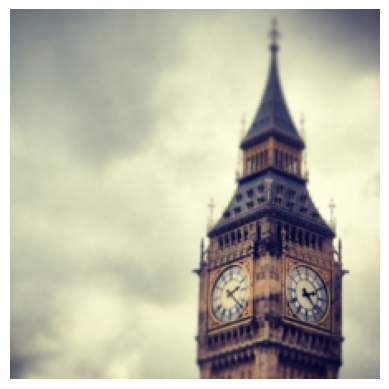

True:  Christmas decorations surrounding a clock tower in a town square.
Predicted:  large clock tower towering over a small town  


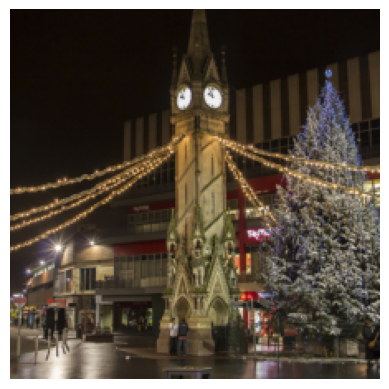

True:  a cellphone sitting on a blue mesh blanket
Predicted:  is an open book with a laptop on it 


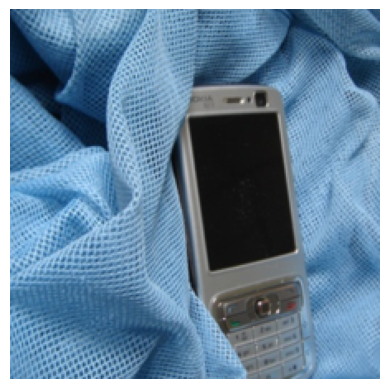

True:  Two zebra grazing on grass next to each other.
Predicted:  zebras are standing together in the dirt   


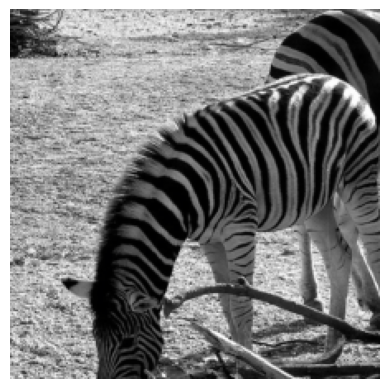

True:  A tennis player shows controlled excitement while a crowd watches.
Predicted:  tennis player is up in the air hoping to striking


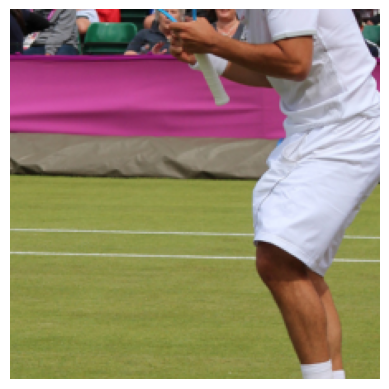

True:  The men are up to their knees in the water.
Predicted:  young man standing on top of a sandy beach holding


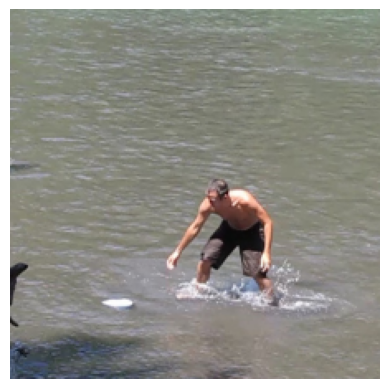

True:  The airplane in the sky is doing tricks while spitting out smoke. 
Predicted:  airplane flying through a blue sky with a cloud and


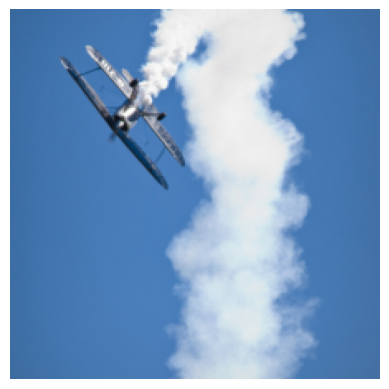

True:  A man drives a motorcycle down a road in the fog.
Predicted:  people on a motorcycle driving down the road  


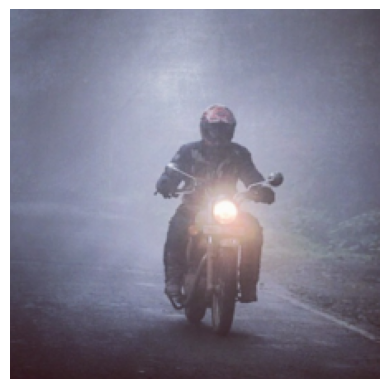

True:  a red and blue plan on the runway getting ready to get passengers 
Predicted:  large passenger jet sitting on top of an airport 


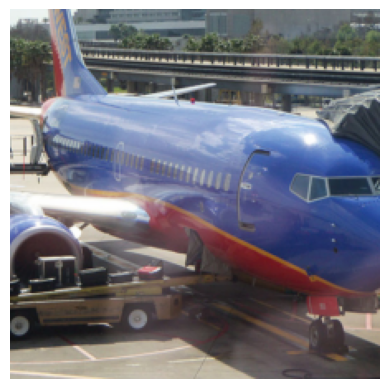

True:  A person that is surfing in the water.
Predicted:  surfer in a wetsuit concentrates while riding a small wave


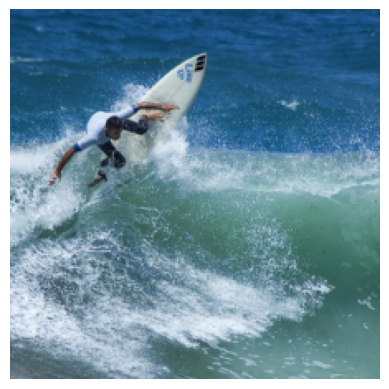

True:  A biker chic in high heel boots is talking to a man at a gas pump.
Predicted:  man riding a motorcycle down a street   


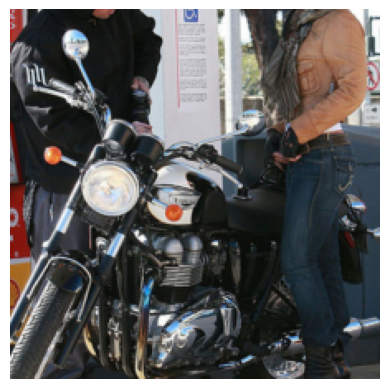

True:  Woman in wet suit considers waves near forested coastline.
Predicted:  people are riding on the back of a wave 


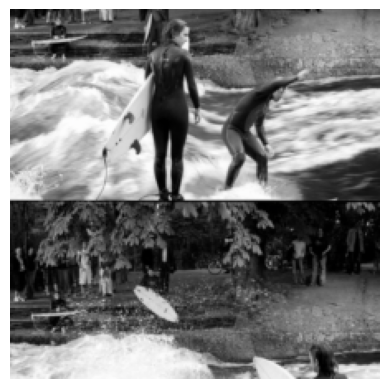

True:  A group of people sitting around a table.
Predicted:  people are sitting at a table with a pizza box


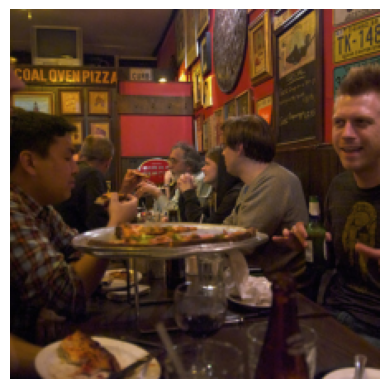

True:  A elephant running after a dog on a mud flat.
Predicted:  elephant with offspring standing next to watering pool  


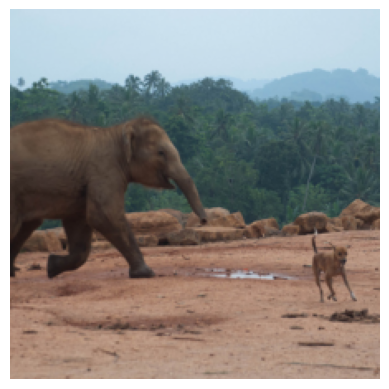

True:  A bathroom filled with toilets and a tub next to a sink.
Predicted:  bathroom with a sink mirror and a bathtub  


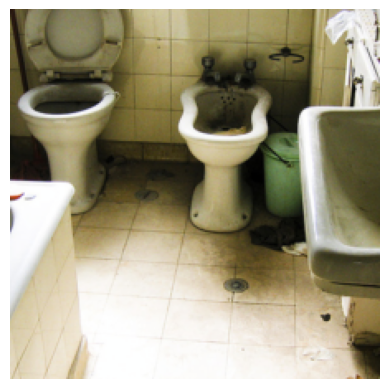

True:  a stop sign and a white and green street sign and a tree
Predicted:  signs that are under a sign that says  


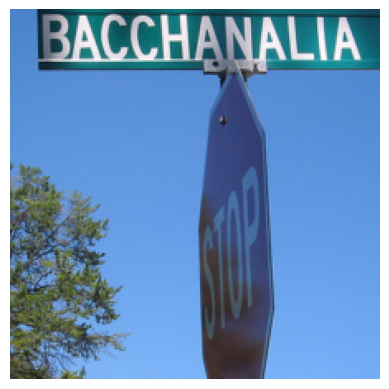

True:  Two children smiling on top of luggage in parking lot
Predicted:  people are riding motor scooters stopped at an intersection 


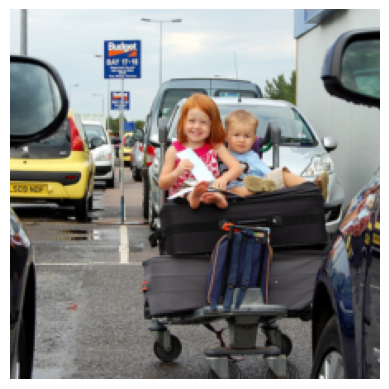

True:  A church with a stain glassed window of the virgin mary.
Predicted:  large brick building with a clock on it  


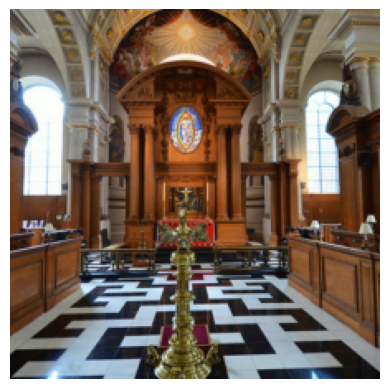

True:  a white male taking pictures with his cellphone
Predicted:  woman with a comically large toothbrush and tie  


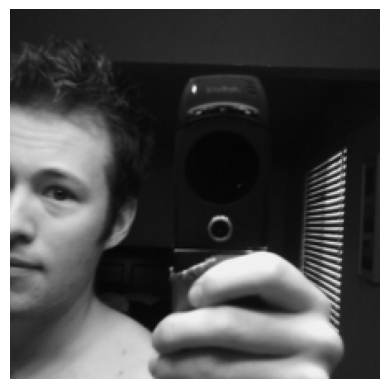

True:  A group of people on the ski slope in their skis. 
Predicted:  people are standing at the ski slope on ski poles


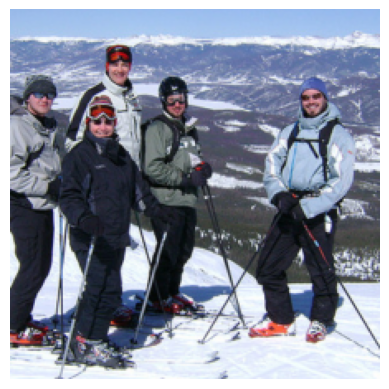

In [26]:
# Inference loop
CGLSTM.eval()
feature_transform.eval()

predictions = []
true_labels = []

for batch_id, (images, captions) in enumerate(val_loader):
        feature_list = []

        for i in range(len(images)): 
            features = feature_mapping_val[captions[0][i]]
            transformed_features = feature_transform(features.flatten())
            feature_list.append(transformed_features)

        # Since feature_list now contains tensors, this should work
        stacked_features = torch.stack(feature_list, dim=0)
        features = stacked_features.to(device)

        caption_indices = CGLSTM.infer(features)
        
        for i, image in enumerate(images):
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]

                caption_words = indices_to_words(caption_indices[i])
                
                truth = captions[0][i]
                pred = caption_words[10:]

                predictions.append(pred)
                true_labels.append(truth)
		
	        # Print the true and predicted captions along with the image
                if batch_id == 0 and i < 20: 
                    print("True: ", truth)
                    print("Predicted: ", pred)
                    imshow(image)

Results obtained with the following hyperparemeters:

trainSize = 1024, 
valSize = 256, 
batchSize = 32, 
num_epochs = 10

Test Scores: 

Maximum BLEU Score (1-1) =  0.41105458056789007

Average BLEU Score (1-1) =  0.05766377192882746

Corpus BLEU score =  0.02747354501891398

In [27]:
evaluate(predictions, true_labels)

Maximum BLEU Score (1-1) =  0.800737402916808
Average BLEU Score (1-1) =  0.07007758864633137
Corpus BLEU score =  0.03776569781825091
